In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import duckdb
import os

In [2]:
from pathlib import Path

data_path = Path("../raw/")

# Leitura dos arquivos CSV
df_transactions = pd.read_csv(f"{data_path}/transactions_data.csv")
df_cards = pd.read_csv(f"{data_path}/cards_data.csv")
df_users = pd.read_csv(f"{data_path}/users_data.csv")
df_mcc = pd.read_json(f"{data_path}/mcc_codes.json", orient='index')
df_fraud_labels = pd.read_json(f"{data_path}/train_fraud_labels.json")

In [3]:
# Configuracao para melhor visualizacao dos graficos 
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

## Análise da planilha transactions_data.csv

In [4]:
df_transactions.describe()

,id,client_id,card_id,merchant_id,zip,mcc
count,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,1.165321e+07,1.330592e+07
mean,1.558402e+07,1.026812e+03,3.475268e+03,4.772376e+04,5.132782e+04,5.565440e+03
std,4.704499e+06,5.816386e+02,1.674356e+03,2.581534e+04,2.940423e+04,8.757002e+02
min,7.475327e+06,0.000000e+00,0.000000e+00,1.000000e+00,1.001000e+03,1.711000e+03
25%,1.150604e+07,5.190000e+02,2.413000e+03,2.588700e+04,2.860200e+04,5.300000e+03
50%,1.557087e+07,1.070000e+03,3.584000e+03,4.592600e+04,4.767000e+04,5.499000e+03
75%,1.965361e+07,1.531000e+03,4.901000e+03,6.757000e+04,7.790100e+04,5.812000e+03
max,2.376187e+07,1.998000e+03,6.144000e+03,1.003420e+05,9.992800e+04,9.402000e+03


In [5]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.2+ GB


In [6]:
df_transactions.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [7]:
df_transactions.isna().sum(), df_transactions.duplicated().sum()

(id                       0
 date                     0
 client_id                0
 card_id                  0
 amount                   0
 use_chip                 0
 merchant_id              0
 merchant_city            0
 merchant_state     1563700
 zip                1652706
 mcc                      0
 errors            13094522
 dtype: int64,
 np.int64(0))

In [8]:
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_transactions['date']

0          2010-01-01 00:01:00
1          2010-01-01 00:02:00
2          2010-01-01 00:02:00
3          2010-01-01 00:05:00
4          2010-01-01 00:06:00
                   ...        
13305910   2019-10-31 23:56:00
13305911   2019-10-31 23:56:00
13305912   2019-10-31 23:57:00
13305913   2019-10-31 23:58:00
13305914   2019-10-31 23:59:00
Name: date, Length: 13305915, dtype: datetime64[ns]

In [9]:
df_transactions['amount'] = df_transactions['amount'] \
    .str.replace('$', '').astype('float')
df_transactions['amount']

0           -77.00
1            14.57
2            80.00
3           200.00
4            46.41
             ...  
13305910      1.11
13305911     12.80
13305912     40.44
13305913      4.00
13305914     12.88
Name: amount, Length: 13305915, dtype: float64

In [10]:
df_transactions[df_transactions['merchant_state'].isna()]

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
7,7475335,2010-01-01 00:14:00,1684,2140,26.46,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN
8,7475336,2010-01-01 00:21:00,335,5131,261.58,Online Transaction,50292,ONLINE,NaN,NaN,7801,NaN
18,7475346,2010-01-01 00:34:00,394,4717,26.04,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN
24,7475353,2010-01-01 00:43:00,301,3742,10.17,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN
26,7475356,2010-01-01 00:45:00,566,3439,16.86,Online Transaction,16798,ONLINE,NaN,NaN,4121,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13305879,23761832,2019-10-31 23:22:00,1556,2972,17.65,Online Transaction,88459,ONLINE,NaN,NaN,5311,NaN
13305880,23761833,2019-10-31 23:22:00,1797,5660,34.81,Online Transaction,15143,ONLINE,NaN,NaN,4784,NaN
13305888,23761843,2019-10-31 23:33:00,1069,5167,59.71,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN
13305897,23761853,2019-10-31 23:39:00,1422,5696,694.30,Online Transaction,70268,ONLINE,NaN,NaN,4722,NaN


In [11]:
# Substituição de valores nulos no dataframe para ONLINE
df_transactions.loc[df_transactions['merchant_city'] == 'ONLINE', 'merchant_state']='ONLINE'
df_transactions.loc[df_transactions['merchant_city']=='ONLINE', 'zip'] = 0

In [12]:
df_transactions.isna().sum()

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state           0
zip                  89006
mcc                      0
errors            13094522
dtype: int64

In [13]:
df_transactions['errors'].fillna("No Errors", inplace=True)

/tmp/ipykernel_4967/2191365140.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_transactions['errors'].fillna("No Errors", inplace=True)


In [14]:
df_transactions[df_transactions['zip'].isna()]

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
581,7476010,2010-01-01 07:53:00,1579,3830,6.51,Swipe Transaction,22204,Puerto Vallarta,Mexico,NaN,5541,No Errors
1026,7476549,2010-01-01 10:03:00,363,5555,8.16,Swipe Transaction,93391,Vatican City,Vatican City,NaN,5812,No Errors
1148,7476704,2010-01-01 10:37:00,363,5555,11.66,Swipe Transaction,93391,Vatican City,Vatican City,NaN,5812,No Errors
1706,7477375,2010-01-01 12:50:00,1266,2478,9.77,Swipe Transaction,22204,Guadalajara,Mexico,NaN,5541,No Errors
1836,7477534,2010-01-01 13:19:00,1266,2478,11.32,Swipe Transaction,75804,Guadalajara,Mexico,NaN,5411,No Errors
...,...,...,...,...,...,...,...,...,...,...,...,...
13304162,23759669,2019-10-31 13:16:00,905,53,18.97,Swipe Transaction,46284,Prague,Czech Republic,NaN,5411,No Errors
13304376,23759927,2019-10-31 14:03:00,905,5053,171.95,Swipe Transaction,51300,Prague,Czech Republic,NaN,3359,No Errors
13304475,23760060,2019-10-31 14:28:00,905,5053,-377.00,Chip Transaction,51300,Prague,Czech Republic,NaN,3359,No Errors
13305061,23760796,2019-10-31 16:45:00,738,5774,317.42,Swipe Transaction,16790,Paris,France,NaN,3389,No Errors


In [15]:
df_transactions['zip'].fillna(0, inplace=True)

/tmp/ipykernel_4967/4224625589.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_transactions['zip'].fillna(0, inplace=True)


In [16]:
df_transactions.isna().sum(), df_transactions.dtypes

(id                0
 date              0
 client_id         0
 card_id           0
 amount            0
 use_chip          0
 merchant_id       0
 merchant_city     0
 merchant_state    0
 zip               0
 mcc               0
 errors            0
 dtype: int64,
 id                         int64
 date              datetime64[ns]
 client_id                  int64
 card_id                    int64
 amount                   float64
 use_chip                  object
 merchant_id                int64
 merchant_city             object
 merchant_state            object
 zip                      float64
 mcc                        int64
 errors                    object
 dtype: object)

<Axes: xlabel='amount'>

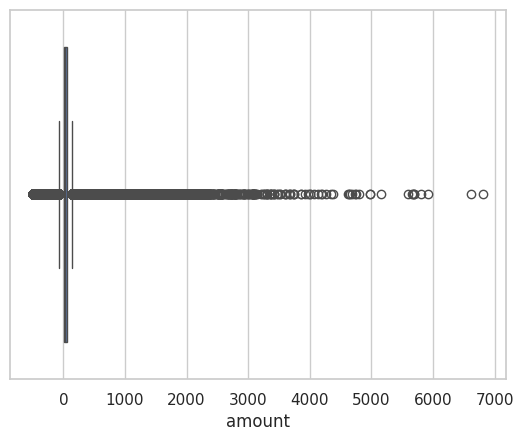

In [17]:
# Grafico 01 - Boxplot do montante para identificar outliers

sns.boxplot(
    data = df_transactions,
    x = 'amount'
)

In [18]:
# removendo os outliers por iqr

Q1, Q3 = df_transactions['amount'].quantile(0.25), df_transactions['amount'].quantile(0.75)
IQR = Q3 - Q1 
lbo = Q1 - 1.5 * IQR 
ubo = Q3 + 1.5 * IQR 

df_transactions = df_transactions[(df_transactions['amount'] >= lbo) & (df_transactions['amount'] <= ubo)]
df_transactions.shape

(12253396, 12)

<Axes: xlabel='amount'>

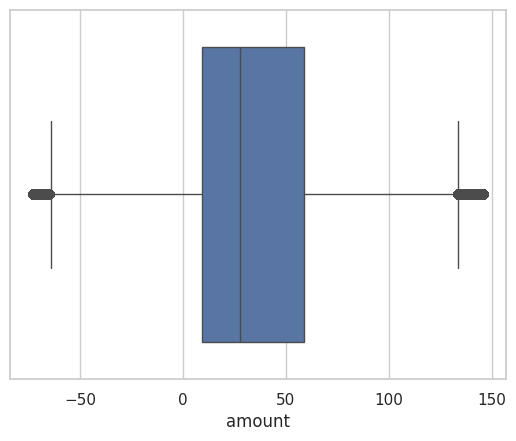

In [19]:
# Grafico 02 - Montante apos remocao de outliers 

sns.boxplot(
    data = df_transactions,
    x = 'amount'
)

## Analise da planilha users_data.csv

In [20]:
df_users.describe()

,id,current_age,retirement_age,birth_year,birth_month,latitude,longitude,credit_score,num_credit_cards
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,45.391500,66.237500,1973.803000,6.439000,37.389225,-91.554765,709.734500,3.073000
std,577.494589,18.414092,3.628867,18.421234,3.565338,5.114324,16.283293,67.221949,1.637379
min,0.000000,18.000000,50.000000,1918.000000,1.000000,20.880000,-159.410000,480.000000,1.000000
25%,499.750000,30.000000,65.000000,1961.000000,3.000000,33.837500,-97.395000,681.000000,2.000000
50%,999.500000,44.000000,66.000000,1975.000000,7.000000,38.250000,-86.440000,711.500000,3.000000
75%,1499.250000,58.000000,68.000000,1989.000000,10.000000,41.200000,-80.130000,753.000000,4.000000
max,1999.000000,101.000000,79.000000,2002.000000,12.000000,61.200000,-68.670000,850.000000,9.000000


In [21]:
df_users.isna().sum(), df_users.duplicated().sum()

(id                   0
 current_age          0
 retirement_age       0
 birth_year           0
 birth_month          0
 gender               0
 address              0
 latitude             0
 longitude            0
 per_capita_income    0
 yearly_income        0
 total_debt           0
 credit_score         0
 num_credit_cards     0
 dtype: int64,
 np.int64(0))

In [22]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   object 
 10  yearly_income      2000 non-null   object 
 11  total_debt         2000 non-null   object 
 12  credit_score       2000 non-null   int64  
 13  num_credit_cards   2000 non-null   int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 218.9+ KB


In [23]:
df_users['gender'] = df_users['gender'].astype('string')
df_users['address'] = df_users['address'].astype('string')

df_users['per_capita_income'] = df_users['per_capita_income'].str.replace('$', '').astype(int)
df_users['yearly_income'] = df_users['yearly_income'].str.replace('$', '').astype(int)
df_users['total_debt'] = df_users['total_debt'].str.replace('$', '').astype(int)

In [24]:
# Conferindo se todos os tipos estao corretos
df_users.dtypes

id                            int64
current_age                   int64
retirement_age                int64
birth_year                    int64
birth_month                   int64
gender               string[python]
address              string[python]
latitude                    float64
longitude                   float64
per_capita_income             int64
yearly_income                 int64
total_debt                    int64
credit_score                  int64
num_credit_cards              int64
dtype: object

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'current_age'),
  Text(1, 0, 'retirement_age'),
  Text(2, 0, 'per_capita_income'),
  Text(3, 0, 'yearly_income'),
  Text(4, 0, 'total_debt'),
  Text(5, 0, 'credit_score'),
  Text(6, 0, 'num_credit_cards')])

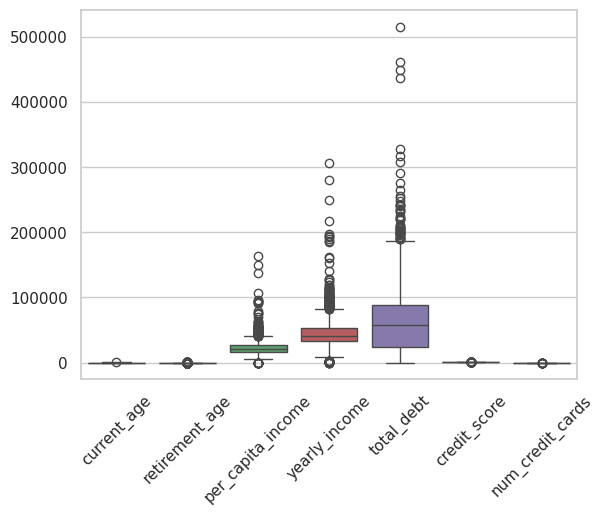

In [25]:
# Analisando outliers 
numeric_cols = [
    'current_age',
    'retirement_age',
    'per_capita_income',
    'yearly_income',
    'total_debt',
    'credit_score',
    'num_credit_cards'
]

sns.boxplot(
    data = df_users[numeric_cols]
)
plt.xticks(rotation=45)

In [26]:
# Tratando os outliers

mask = pd.Series(True, index=df_users.index)

for col in numeric_cols:
    Q1, Q3 = df_users[col].quantile(0.25), df_users[col].quantile(0.75)
    IQR = Q3 - Q1 
    lbo = Q1 - 1.5 * IQR
    ubo = Q3 + 1.5 * IQR 
    
    mask &= df_users[col].between(lbo, ubo)

df_users = df_users[mask]

22358

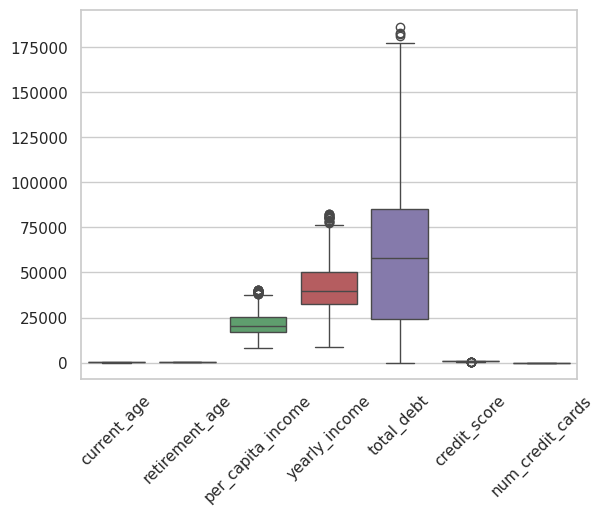

In [27]:
# Analisando apos a remocao dos outliers
sns.boxplot(
    data = df_users[numeric_cols]
)
plt.xticks(rotation=45)
df_users.size

<Axes: xlabel='credit_score', ylabel='Count'>

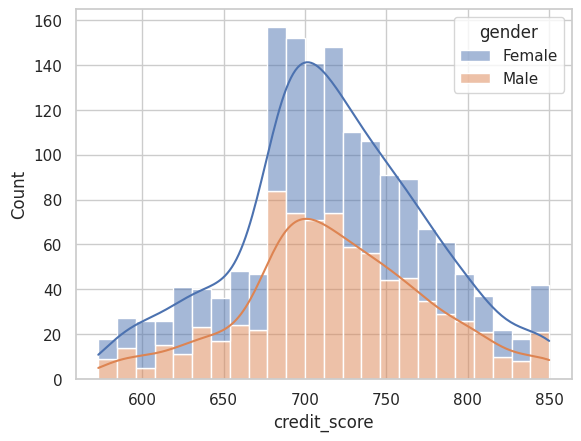

In [28]:
# Grafico 1 - Score de credito por genero 

sns.histplot(
    data=df_users,
    x = 'credit_score',
    hue = 'gender',
    multiple='stack',
    kde=True
)

<Axes: xlabel='num_credit_cards', ylabel='Count'>

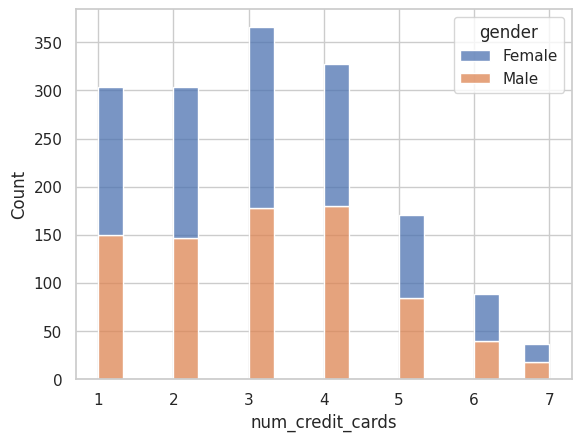

In [29]:
# Grafico 2 - Quantidade de cartoes de credito por genero 

sns.histplot(
    data = df_users,
    x = 'num_credit_cards',
    hue = 'gender',
    multiple='stack'
)

<Axes: xlabel='yearly_income', ylabel='Count'>

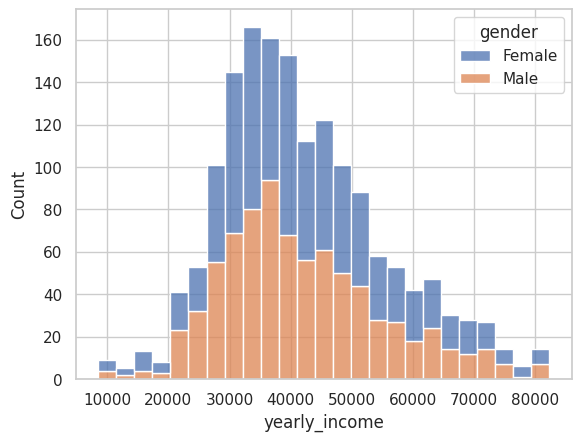

In [30]:
# Grafico 3 - Ganhos anuais por genero 

sns.histplot(
    data = df_users,
    x = 'yearly_income',
    hue = 'gender',
    multiple='stack'
)

<Axes: xlabel='yearly_income', ylabel='total_debt'>

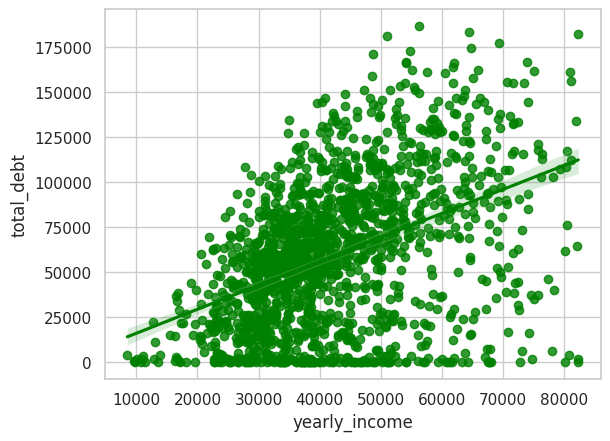

In [31]:
# Grafico 4 - Grafico de ganhos anuais por divida total 

sns.regplot(
    data = df_users,
    x = 'yearly_income',
    y = 'total_debt',
    color='green'
)

## Analise da planilha cards_data.csv

In [32]:
df_cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6146 non-null   int64 
 1   client_id              6146 non-null   int64 
 2   card_brand             6146 non-null   object
 3   card_type              6146 non-null   object
 4   card_number            6146 non-null   int64 
 5   expires                6146 non-null   object
 6   cvv                    6146 non-null   int64 
 7   has_chip               6146 non-null   object
 8   num_cards_issued       6146 non-null   int64 
 9   credit_limit           6146 non-null   object
 10  acct_open_date         6146 non-null   object
 11  year_pin_last_changed  6146 non-null   int64 
 12  card_on_dark_web       6146 non-null   object
dtypes: int64(6), object(7)
memory usage: 624.3+ KB


In [33]:
df_cards.describe()

,id,client_id,card_number,cvv,num_cards_issued,year_pin_last_changed
count,6146.000000,6146.000000,6.146000e+03,6146.000000,6146.000000,6146.000000
mean,3072.500000,994.939636,4.820426e+15,506.220794,1.503091,2013.436707
std,1774.341709,578.614626,1.328582e+15,289.431123,0.519191,4.270699
min,0.000000,0.000000,3.001055e+14,0.000000,1.000000,2002.000000
25%,1536.250000,492.250000,4.486365e+15,257.000000,1.000000,2010.000000
50%,3072.500000,992.000000,5.108957e+15,516.500000,1.000000,2013.000000
75%,4608.750000,1495.000000,5.585237e+15,756.000000,2.000000,2017.000000
max,6145.000000,1999.000000,6.997197e+15,999.000000,3.000000,2020.000000


In [34]:
df_cards.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [35]:
df_cards.isna().sum(), df_cards.duplicated().sum()

(id                       0
 client_id                0
 card_brand               0
 card_type                0
 card_number              0
 expires                  0
 cvv                      0
 has_chip                 0
 num_cards_issued         0
 credit_limit             0
 acct_open_date           0
 year_pin_last_changed    0
 card_on_dark_web         0
 dtype: int64,
 np.int64(0))

In [36]:
df_cards['credit_limit'] = df_cards['credit_limit'].str.replace('$', "").astype(float)

In [37]:
df_cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     6146 non-null   int64  
 1   client_id              6146 non-null   int64  
 2   card_brand             6146 non-null   object 
 3   card_type              6146 non-null   object 
 4   card_number            6146 non-null   int64  
 5   expires                6146 non-null   object 
 6   cvv                    6146 non-null   int64  
 7   has_chip               6146 non-null   object 
 8   num_cards_issued       6146 non-null   int64  
 9   credit_limit           6146 non-null   float64
 10  acct_open_date         6146 non-null   object 
 11  year_pin_last_changed  6146 non-null   int64  
 12  card_on_dark_web       6146 non-null   object 
dtypes: float64(1), int64(6), object(6)
memory usage: 624.3+ KB


<Axes: xlabel='card_brand', ylabel='count'>

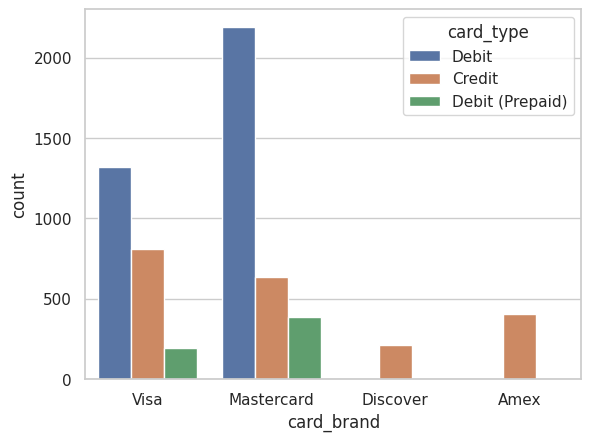

In [38]:
# Grafico 01 - Bandeiras de cartao por tipo de cartao

sns.countplot(
    data = df_cards,
    x = 'card_brand',
    hue = 'card_type'
)

<Axes: xlabel='has_chip', ylabel='count'>

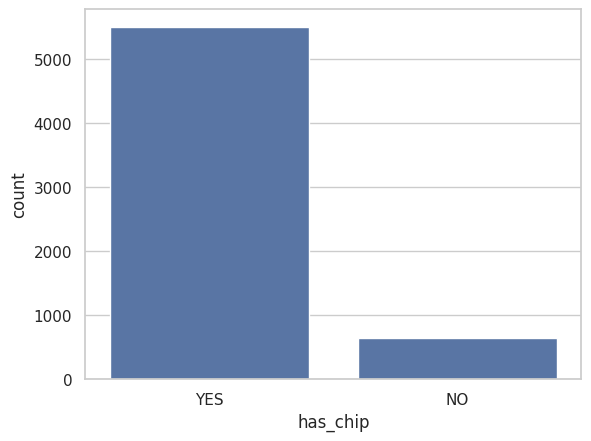

In [39]:
# Grafico 2 - Cartoes com chip vs sem chip
  
sns.countplot(data=df_cards, x='has_chip')

<Axes: xlabel='card_on_dark_web', ylabel='count'>

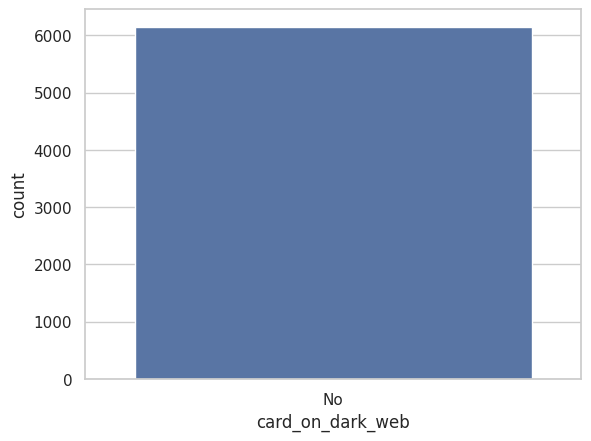

In [40]:
# Grafico 3 - Cartoes encontrados na Dark Web 

sns.countplot(
    data = df_cards,
    x = 'card_on_dark_web'
)

<Axes: xlabel='credit_limit', ylabel='Count'>

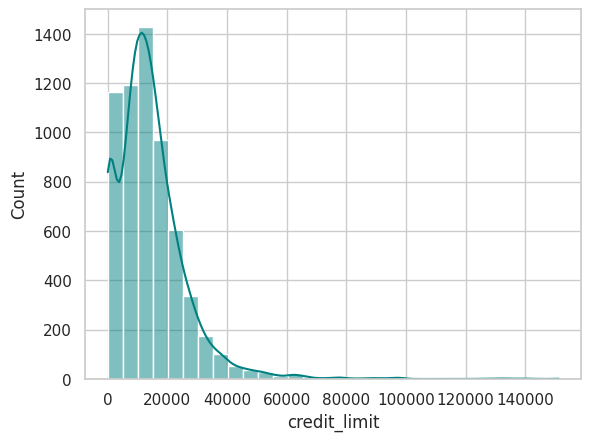

In [41]:
# Grafico 4 - Distribuicao de cartoes por limite de credito

sns.histplot(data=df_cards, x='credit_limit', kde=True, bins=30, color='teal')

<Axes: xlabel='num_cards_issued', ylabel='credit_limit'>

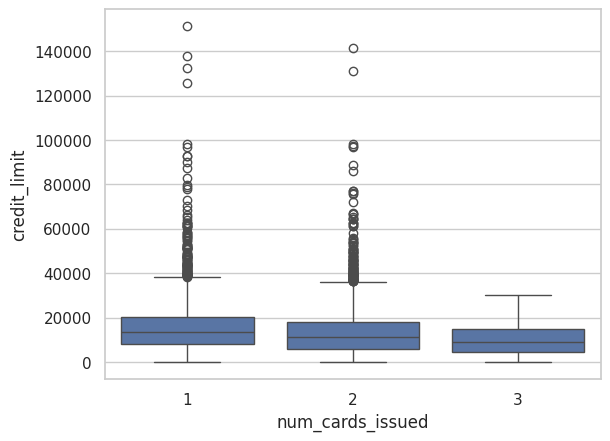

In [42]:
# Grafico 5 - Clientes com mais cartoes tem maior limite? 

sns.boxplot(
    data = df_cards,
    x = 'num_cards_issued',
    y = 'credit_limit'
)

In [43]:
df_mcc.reset_index(inplace=True)
df_mcc.columns = ["MCC_Code", "Description"]
df_mcc

,MCC_Code,Description
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees
...,...,...
104,7549,Towing Services
105,5941,Sporting Goods Stores
106,5722,Household Appliance Stores
107,3009,Fabricated Structural Metal Products


In [44]:
df_mcc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MCC_Code     109 non-null    int64 
 1   Description  109 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [45]:
df_fraud_labels.reset_index(inplace=True)

In [46]:
df_fraud_labels.columns = ["id", "Target"]

In [47]:
df_fraud_labels

,id,Target
0,10649266,No
1,23410063,No
2,9316588,No
3,12478022,No
4,9558530,No
...,...,...
8914958,14064699,No
8914959,7676538,No
8914960,15131030,No
8914961,17244732,No


In [48]:
df_fraud_labels[['Target']].describe()

,Target
count,8914963
unique,2
top,No
freq,8901631


In [49]:
df_fraud_labels['Target'].value_counts()

Target
No     8901631
Yes      13332
Name: count, dtype: int64

In [50]:
df_transactions.columns.to_list()
df_transactions = df_transactions.rename(columns={"id": "transaction_id"})

In [51]:
df_transactions.columns.to_list()

['transaction_id',
 'date',
 'client_id',
 'card_id',
 'amount',
 'use_chip',
 'merchant_id',
 'merchant_city',
 'merchant_state',
 'zip',
 'mcc',
 'errors']

In [52]:
df_transactions.transaction_id.max()

np.int64(23761874)

In [53]:
df_transactions.dtypes

print(f"df_transactions - Tamanho ANTES: {df_transactions.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


df_transactions = df_transactions.astype(
    {
        'transaction_id': 'int32',
        'client_id': 'int32',
        'card_id': 'int32',
        'merchant_id': 'int32',
        'amount': 'float32',
        'mcc': 'int16',
        'zip': 'Int32',
        'use_chip': 'category',
        'merchant_city': 'category',
        'merchant_state': 'category',
        'errors': 'category'
    }
)

print(f"df_transactions - Tamanho DEPOIS: {df_transactions.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Novos DTypes de df_transactions:\n{df_transactions.dtypes}")
print("-" * 30)

df_transactions - Tamanho ANTES: 3563.53 MB
df_transactions - Tamanho DEPOIS: 573.56 MB
Novos DTypes de df_transactions:
transaction_id             int32
date              datetime64[ns]
client_id                  int32
card_id                    int32
amount                   float32
use_chip                category
merchant_id                int32
merchant_city           category
merchant_state          category
zip                        Int32
mcc                        int16
errors                  category
dtype: object
------------------------------


In [54]:
df_cards.columns.to_list()
df_cards = df_cards.rename(columns={"id": "card_id"})
df_cards.columns.tolist()

['card_id',
 'client_id',
 'card_brand',
 'card_type',
 'card_number',
 'expires',
 'cvv',
 'has_chip',
 'num_cards_issued',
 'credit_limit',
 'acct_open_date',
 'year_pin_last_changed',
 'card_on_dark_web']

In [55]:
df_cards.dtypes

print(f"df_cards - Tamanho ANTES: {df_cards.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

card_dtype_map = {
    'card_id': 'int32',
    'client_id': 'int32',
    
    'cvv': 'int16',
    'num_cards_issued': 'int8',
    'year_pin_last_changed': 'int16',
    'credit_limit': 'float32',
    'card_number': 'int64',
    
    'card_brand': 'category',
    'card_type': 'category',
    'has_chip': 'category',
    'card_on_dark_web': 'category',
}

df_cards = df_cards.astype(card_dtype_map)

df_cards['expires'] = pd.to_datetime(df_cards['expires'], errors='coerce')
df_cards['acct_open_date'] = pd.to_datetime(df_cards['acct_open_date'], errors='coerce')


print(f"df_cards - Tamanho DEPOIS: {df_cards.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Novos DTypes de df_cards:\n{df_cards.dtypes}")

df_cards - Tamanho ANTES: 2.24 MB
df_cards - Tamanho DEPOIS: 0.26 MB
Novos DTypes de df_cards:
card_id                           int32
client_id                         int32
card_brand                     category
card_type                      category
card_number                       int64
expires                  datetime64[ns]
cvv                               int16
has_chip                       category
num_cards_issued                   int8
credit_limit                    float32
acct_open_date           datetime64[ns]
year_pin_last_changed             int16
card_on_dark_web               category
dtype: object


/tmp/ipykernel_4967/2830870841.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cards['expires'] = pd.to_datetime(df_cards['expires'], errors='coerce')
/tmp/ipykernel_4967/2830870841.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cards['acct_open_date'] = pd.to_datetime(df_cards['acct_open_date'], errors='coerce')


In [56]:
df_users.columns.to_list()

df_users = df_users.rename(columns={'id': 'client_id'})
df_users.columns.to_list()


['client_id',
 'current_age',
 'retirement_age',
 'birth_year',
 'birth_month',
 'gender',
 'address',
 'latitude',
 'longitude',
 'per_capita_income',
 'yearly_income',
 'total_debt',
 'credit_score',
 'num_credit_cards']

In [57]:
df_users.dtypes



print(f"df_users - Tamanho ANTES: {df_users.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

user_dtype_map = {
    'client_id': 'int32',
    
    'current_age': 'int8',
    'retirement_age': 'int8',
    'birth_month': 'int8',
    'num_credit_cards': 'int8',
    'birth_year': 'int16',
    'credit_score': 'int16',
    
    'per_capita_income': 'int32',
    'yearly_income': 'int32',
    'total_debt': 'int32',
    
    'latitude': 'float32',
    'longitude': 'float32',
    
    'gender': 'category',
    'address': 'category', 
}

df_users = df_users.astype(user_dtype_map)

print(f"df_users - Tamanho DEPOIS: {df_users.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Novos DTypes de df_users:\n{df_users.dtypes}")

df_users - Tamanho ANTES: 0.34 MB
df_users - Tamanho DEPOIS: 0.23 MB
Novos DTypes de df_users:
client_id               int32
current_age              int8
retirement_age           int8
birth_year              int16
birth_month              int8
gender               category
address              category
latitude              float32
longitude             float32
per_capita_income       int32
yearly_income           int32
total_debt              int32
credit_score            int16
num_credit_cards         int8
dtype: object


In [58]:
df_mcc.columns.to_list()

['MCC_Code', 'Description']

In [59]:
df_mcc.dtypes

MCC_Code        int64
Description    object
dtype: object

In [60]:
print(f"df_mcc - Tamanho ANTES: {df_mcc.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

mcc_dtype_map = {
    # ID otimizado para o menor tipo possível
    'MCC_Code': 'int16', 
    
    # String para Categoria
    'Description': 'category'
}

# Aplicar a conversão
df_mcc = df_mcc.astype(mcc_dtype_map)

print(f"df_mcc - Tamanho DEPOIS: {df_mcc.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Novos DTypes de df_mcc:\n{df_mcc.dtypes}")

df_mcc - Tamanho ANTES: 0.01 MB
df_mcc - Tamanho DEPOIS: 0.01 MB
Novos DTypes de df_mcc:
MCC_Code          int16
Description    category
dtype: object


In [61]:
df_mcc = df_mcc.rename(columns={'MCC_Code': 'mcc'})

In [62]:
df_mcc

,mcc,Description
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees
...,...,...
104,7549,Towing Services
105,5941,Sporting Goods Stores
106,5722,Household Appliance Stores
107,3009,Fabricated Structural Metal Products


In [63]:
df_fraud_labels.columns.to_list()

['id', 'Target']

In [64]:
df_fraud_labels.Target.value_counts()

Target
No     8901631
Yes      13332
Name: count, dtype: int64

In [65]:
df_fraud_labels.dtypes

print(f"df_fraud_labels - Tamanho ANTES: {df_fraud_labels.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

fraud_dtype_map = {
    'id': 'int32', 
    
    'Target': 'category' 
}

df_fraud_labels = df_fraud_labels.astype(fraud_dtype_map)

print(f"df_fraud_labels - Tamanho DEPOIS: {df_fraud_labels.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Novos DTypes de df_fraud_labels:\n{df_fraud_labels.dtypes}")


df_fraud_labels - Tamanho ANTES: 501.63 MB
df_fraud_labels - Tamanho DEPOIS: 42.51 MB
Novos DTypes de df_fraud_labels:
id           int32
Target    category
dtype: object


In [66]:
df_fraud_labels = df_fraud_labels.rename(columns={"id": "transaction_id"})

In [67]:
df_fraud_labels.columns

Index(['transaction_id', 'Target'], dtype='object')

# Fazendo o merge

In [68]:
merged = pd.merge(
    left=df_transactions,
    right=df_cards,
    how='left',
    on='card_id',
    suffixes=('_tran', "_card")
)

merged.columns.to_list()

['transaction_id',
 'date',
 'client_id_tran',
 'card_id',
 'amount',
 'use_chip',
 'merchant_id',
 'merchant_city',
 'merchant_state',
 'zip',
 'mcc',
 'errors',
 'client_id_card',
 'card_brand',
 'card_type',
 'card_number',
 'expires',
 'cvv',
 'has_chip',
 'num_cards_issued',
 'credit_limit',
 'acct_open_date',
 'year_pin_last_changed',
 'card_on_dark_web']

In [ ]:
merged = merged.drop(columns=['client_id_card'])
merged - merged.rename(columns={'client_id_tran': 'client_id'})

merged_transactions_cards_users = pd.merge(
    left=merged,
    right=df_users,
    how='left',
    on='client_id',
    suffixes=('_card', "_user")
)

In [ ]:
df_transactions_cards_users_mcc= pd.merge(
    left=merged_transactions_cards_users,
    right=df_mcc,
    how='left',
    on='mcc',
    suffixes=('_final', '_mcc')
)

if 'Description' in df_transactions_cards_users_mcc.columns:
    df_final = df_transactions_cards_users_mcc.rename(columns={'Description': 'mcc_description'})

In [ ]:
print("4/4: Realizando merge com df_fraud_labels (Chave: transaction_id)...")

df_final = pd.merge(
    left=df_final,
    right=df_fraud_labels,
    how='left',
    on='transaction_id',
    suffixes=('_base', '_fraud')
)

print("\n--- Tabela Única Finalizada! ---")
print(f"Total de linhas na Tabela Única: {len(df_final)}")
print(f"Total de colunas: {len(df_final.columns)}")
print("O DataFrame (df_final) agora contém transações, cartões, usuários, MCC e o rótulo de fraude. Pronto para o PostgreSQL!")

## Guardando os dados analisados

In [69]:
df_cards.shape, df_transactions.shape, df_users.shape, df_mcc.shape, df_fraud_labels.shape

((6146, 13), (12253396, 12), (1597, 14), (109, 2), (8914963, 2))